<a href="https://colab.research.google.com/github/Kostia9/Data-Analysis-2025/blob/main/Telco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os, math, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict, learning_curve
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, average_precision_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

from joblib import dump

print("Python:", sys.version.split()[0])
import sklearn
print("sklearn:", sklearn.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)



Python: 3.12.11
sklearn: 1.6.1
numpy: 2.0.2
pandas: 2.2.2


## Опис набору даних

Цей набір даних взято з IBM Sample Data Sets і має на меті передбачити відтік клієнтів.

Він містить інформацію про:

*   **Клієнтів, які пішли протягом останнього місяця:** Вказано у стовпці `Churn`.
*   **Послуги:** Деталі щодо телефону, декількох ліній, інтернету, онлайн-безпеки, онлайн-резервного копіювання, захисту пристроїв, технічної підтримки, а також потокового телебачення та фільмів.
*   **Інформація про обліковий запис клієнта:** Термін перебування клієнтом, тип контракту, спосіб оплати, безпаперове виставлення рахунків, щомісячні та загальні платежі.
*   **Демографічна інформація про клієнтів:** Стать, віковий діапазон (`SeniorCitizen`), а також наявність партнерів та утриманців.

Мета полягає в аналізі цих даних для розробки цілеспрямованих програм утримання клієнтів.

| Column          | Description                                                       |
|-----------------|-------------------------------------------------------------------|
| customerID      | Customer ID                                                       |
| gender          | Whether the customer is a male or a female                        |
| SeniorCitizen   | Whether the customer is a senior citizen or not (1, 0)            |
| Partner         | Whether the customer has a partner or not (Yes, No)               |
| Dependents      | Whether the customer has dependents or not (Yes, No)              |
| tenure          | Number of months the customer has stayed with the company         |
| PhoneService    | Whether the customer has a phone service or not (Yes, No)         |
| MultipleLines   | Whether the customer has multiple lines or not (Yes, No, No phone service) |
| InternetService | Customer’s internet service provider (DSL, Fiber optic, No)       |
| OnlineSecurity  | Whether the customer has online security or not (Yes, No, No internet service) |


In [2]:
df = pd.read_csv("https://drive.google.com/uc?id=18G8QobhAgCRv_kBqnodiJrE3DgNqoGTK")
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df = df.drop('customerID', axis=1)

In [5]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isna().sum())

11


In [6]:
df = df.dropna()
print(df.shape)

(7032, 20)


In [7]:
for col in df.columns:
    if df[col].nunique() < 10:
        print(f"{col}: {df[col].unique()}")
    else:
        print(f"{col}: {df[col].nunique()}")

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: 72
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: 1584
TotalCharges: 6530
Churn: ['No' 'Yes']


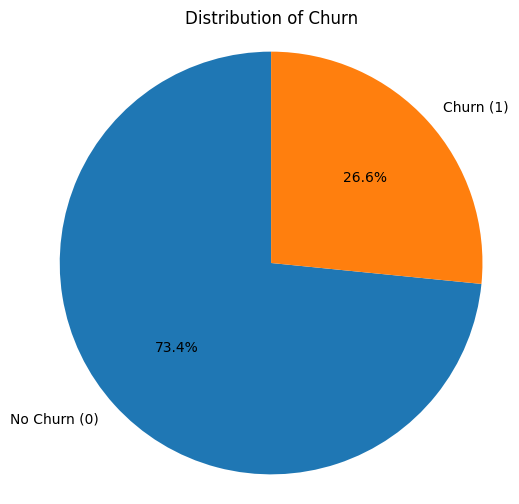

In [8]:
churn_counts = df['Churn'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['No Churn (0)', 'Churn (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Churn')
plt.axis('equal')
plt.show()

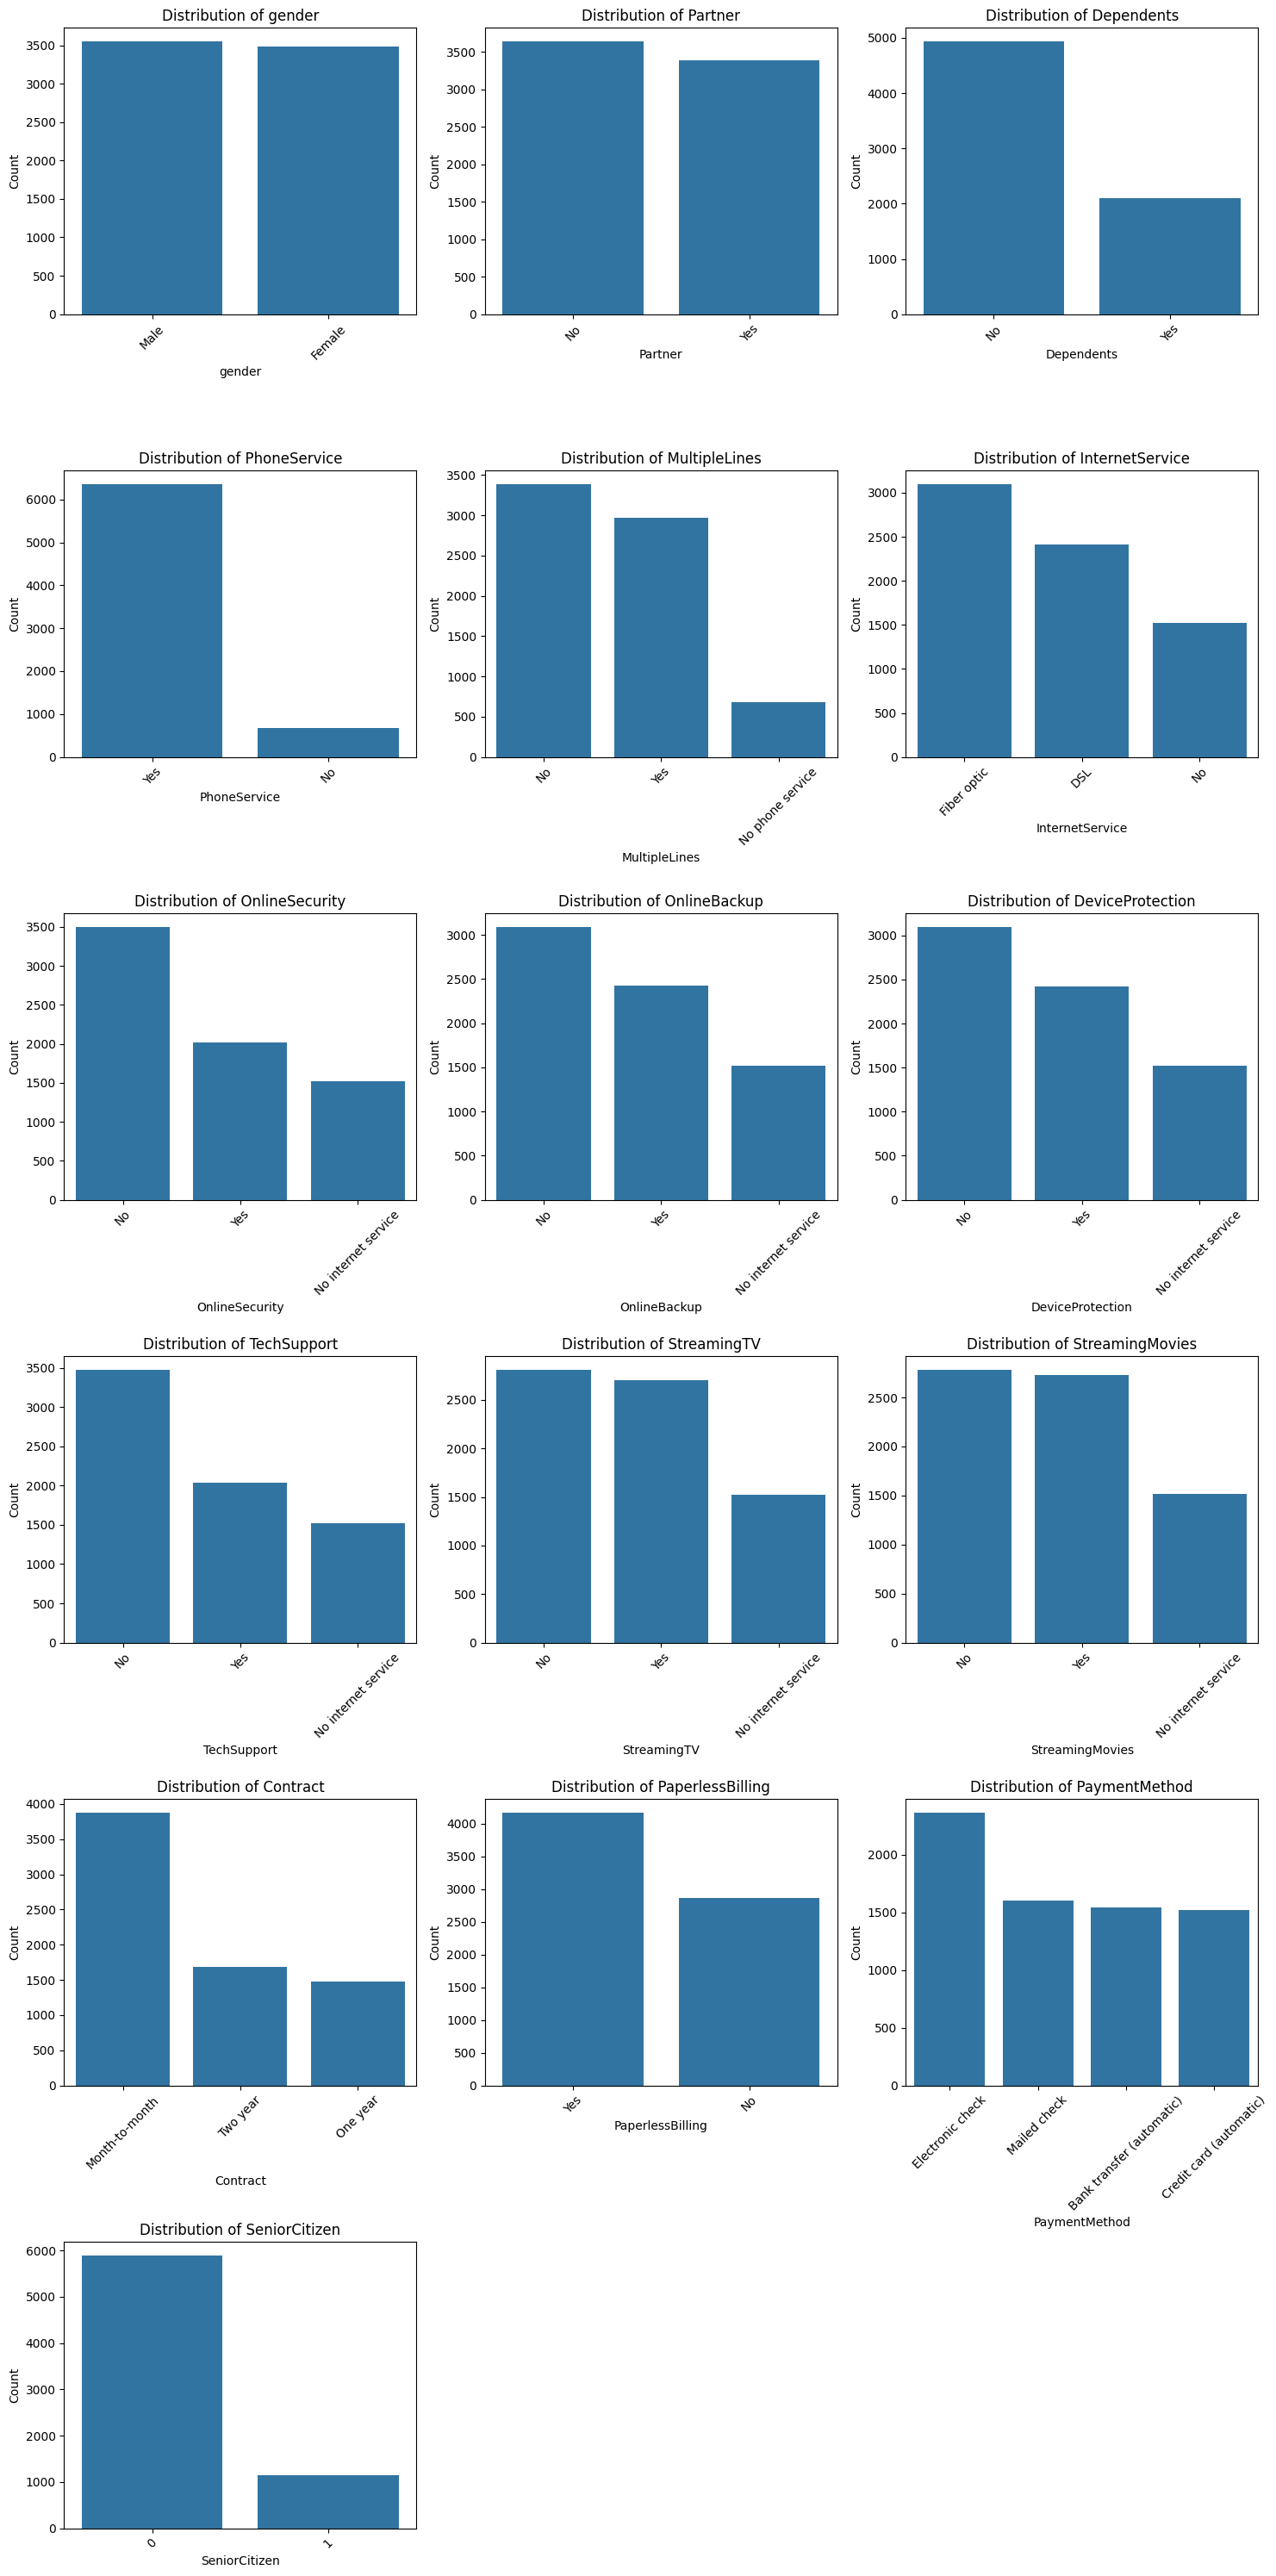

In [9]:
# Visualize distributions of all columns except 'Churn'
cols_to_plot = [col for col in df.columns if col != 'Churn' and df[col].dtype == 'object']
cols_to_plot.append('SeniorCitizen')


n_cols = 3  # Number of columns in the grid
nrows = int(math.ceil(len(cols_to_plot) / n_cols)) # Calculate number of rows

fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

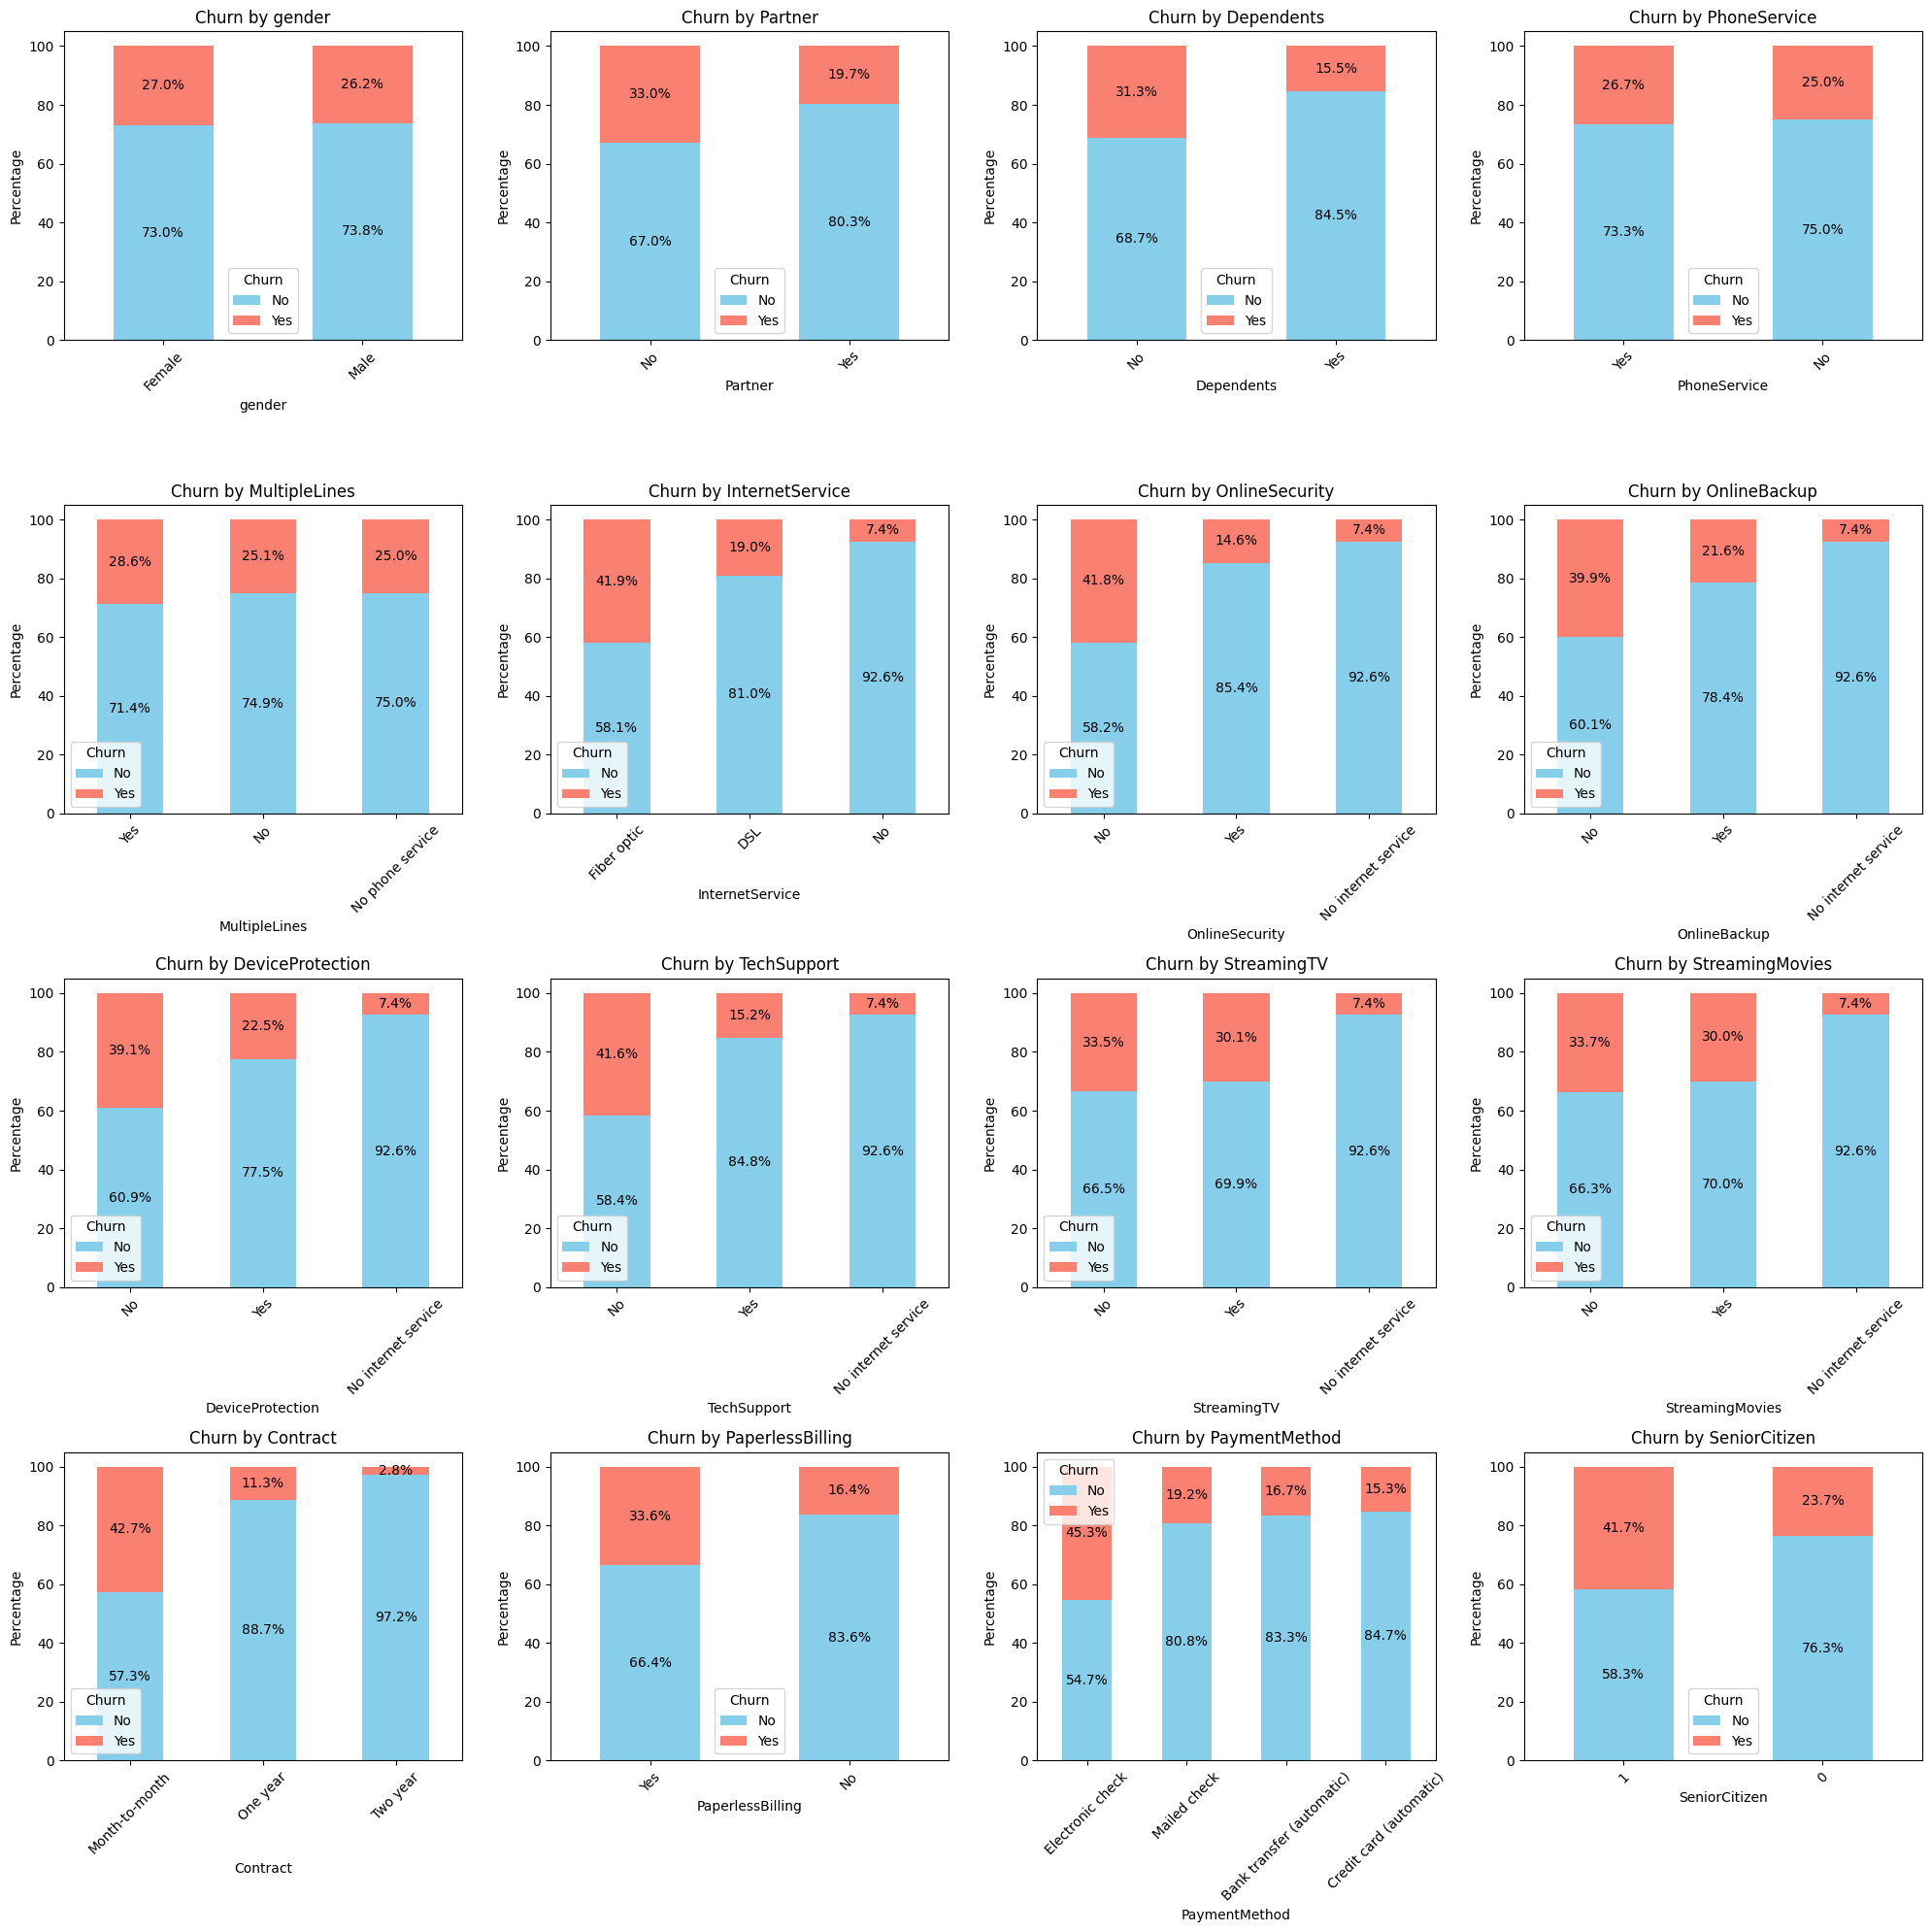

In [10]:
churn_palette_numeric = {0: 'skyblue', 1: 'salmon'}
churn_palette_object = {'No': 'skyblue', 'Yes': 'salmon'}

# Set up 4x4 grid
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    churn_percentage = (
        df.groupby(col)['Churn']
        .value_counts(normalize=True)
        .unstack()
        .mul(100)
        .sort_values(by='Yes', ascending=False)
    )

    churn_percentage.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=[churn_palette_object['No'], churn_palette_object['Yes']]
        if df['Churn'].dtype == 'object'
        else [churn_palette_numeric[0], churn_palette_numeric[1]]
    )

    ax.set_title(f'Churn by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage')
    ax.tick_params(axis='x', rotation=45)

    # Show % labels
    for container in ax.containers:
        labels = [
            f'{h:.1f}%' if (h := v.get_height()) > 0 else '' for v in container
        ]
        ax.bar_label(container, labels=labels, label_type='center')

# Hide any unused subplots if df has < 16 cols
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


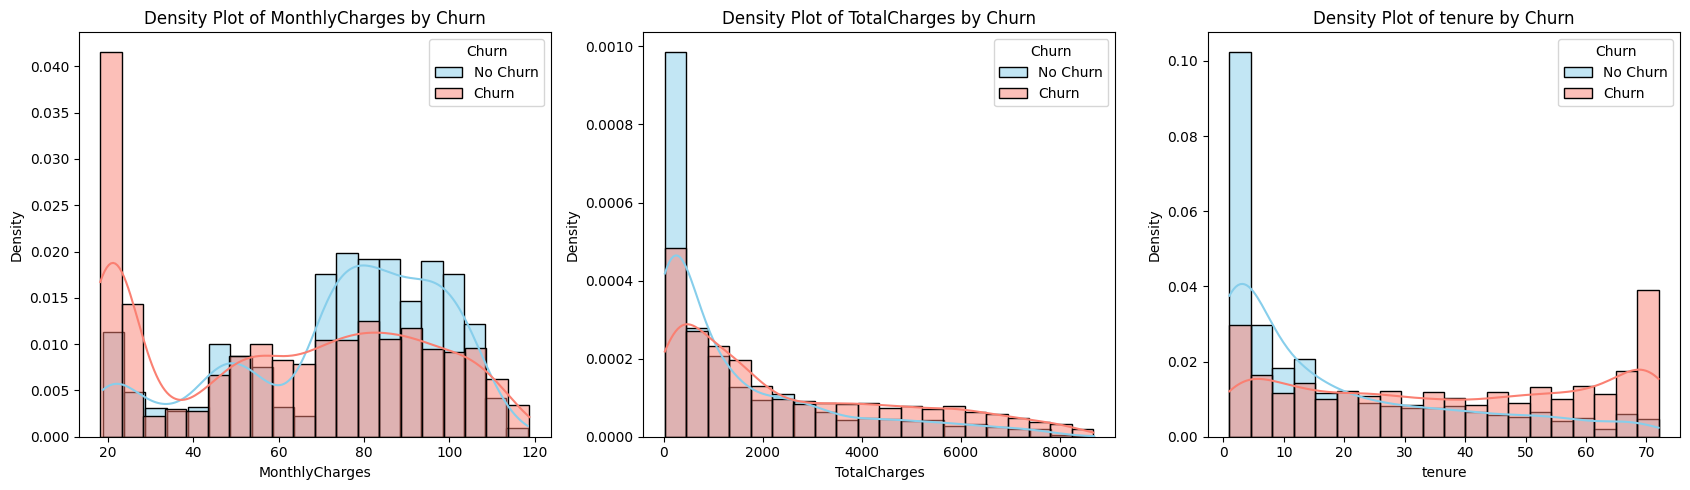

In [11]:
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df[df['Churn'] == 'Yes'], x=col, kde=True, stat='density', bins=20, color='skyblue', label='No Churn', ax=axes[i])
    sns.histplot(data=df[df['Churn'] == 'No'], x=col, kde=True, stat='density', bins=20, color='salmon', label='Churn', ax=axes[i])
    axes[i].set_title(f'Density Plot of {col} by Churn')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Churn') # Adjust labels based on hue order

plt.tight_layout()
plt.show()


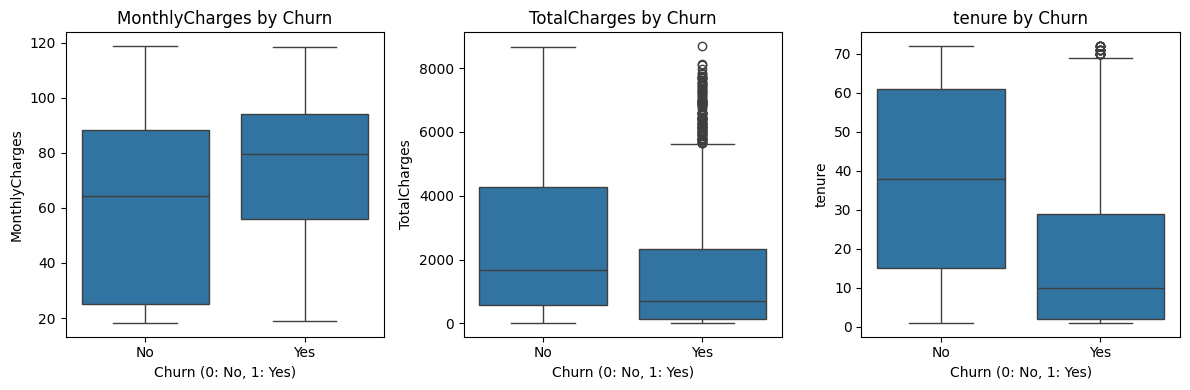

In [12]:
# Boxplots of numerical features by Churn status
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'tenure']

nrows = int(math.ceil(len(numeric_cols) / 3)) # Adjust nrows based on number of numeric columns
fig, axes = plt.subplots(nrows, 3, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x='Churn', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{col} by Churn')
    axes[i].set_xlabel('Churn (0: No, 1: Yes)')
    axes[i].set_ylabel(col)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [13]:
# Convert 'gender' to 0/1
print(f"Converting column 'gender' to 0/1")
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

for col in df.columns:
    if df[col].dtype == 'object':
        if df[col].nunique() == 2 and all(val in ['No', 'Yes'] for val in df[col].unique()):
            print(f"Converting column '{col}' from 'No'/'Yes' to 0/1")
            df[col] = df[col].map({'No': 0, 'Yes': 1})
        else:
            print(f"Applying One-Hot Encoding to column '{col}'")
            df = pd.get_dummies(df, columns=[col], prefix=col, dtype=int)

df.head()

Converting column 'gender' to 0/1
Converting column 'Partner' from 'No'/'Yes' to 0/1
Converting column 'Dependents' from 'No'/'Yes' to 0/1
Converting column 'PhoneService' from 'No'/'Yes' to 0/1
Applying One-Hot Encoding to column 'MultipleLines'
Applying One-Hot Encoding to column 'InternetService'
Applying One-Hot Encoding to column 'OnlineSecurity'
Applying One-Hot Encoding to column 'OnlineBackup'
Applying One-Hot Encoding to column 'DeviceProtection'
Applying One-Hot Encoding to column 'TechSupport'
Applying One-Hot Encoding to column 'StreamingTV'
Applying One-Hot Encoding to column 'StreamingMovies'
Applying One-Hot Encoding to column 'Contract'
Converting column 'PaperlessBilling' from 'No'/'Yes' to 0/1
Applying One-Hot Encoding to column 'PaymentMethod'
Converting column 'Churn' from 'No'/'Yes' to 0/1


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


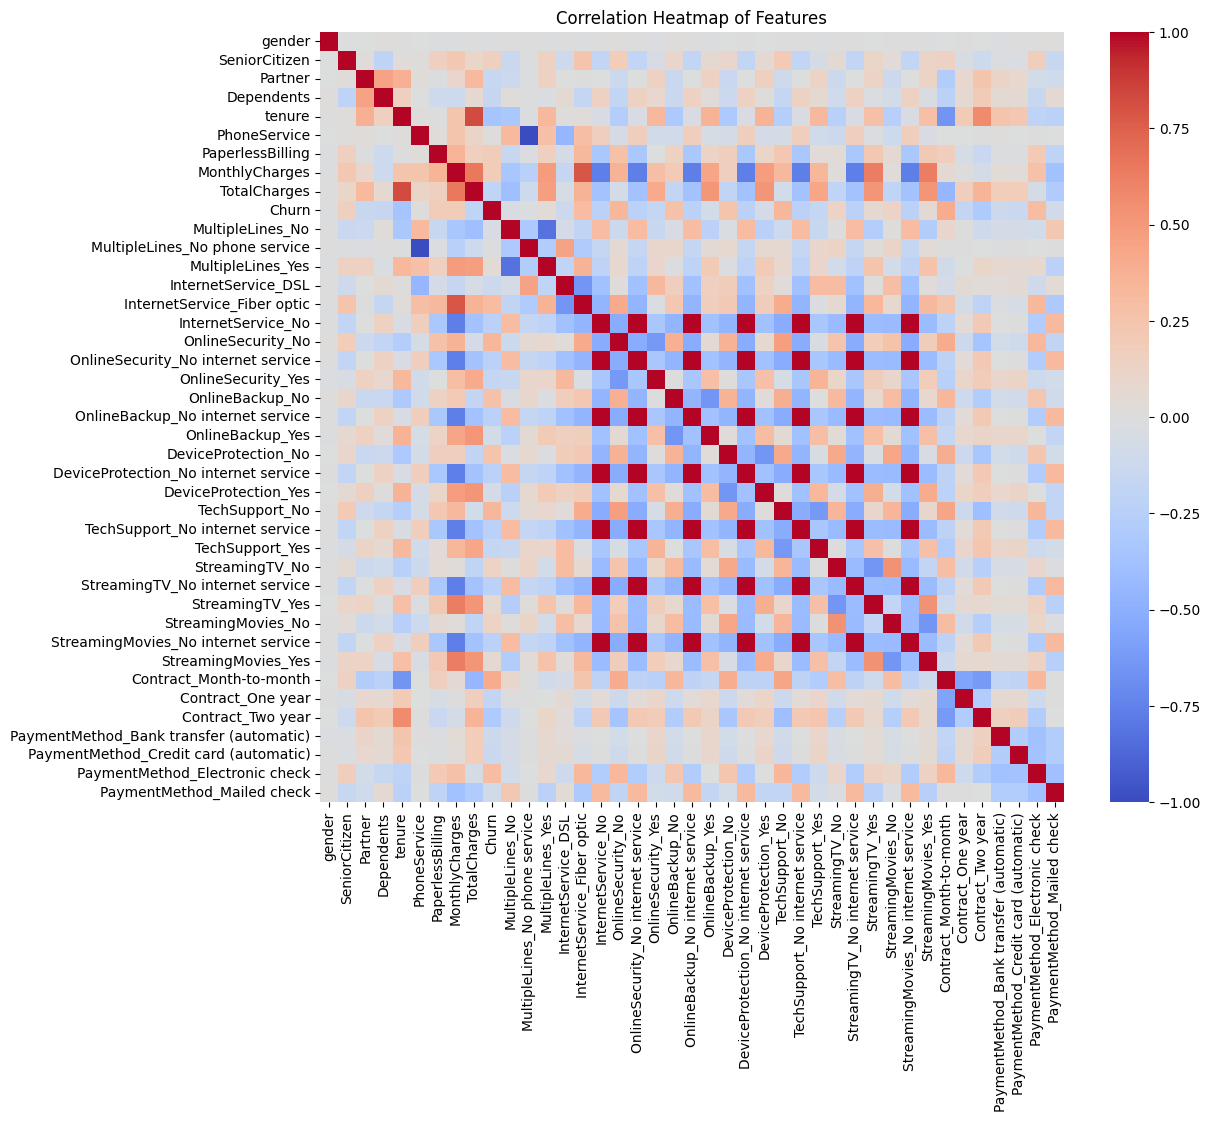

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

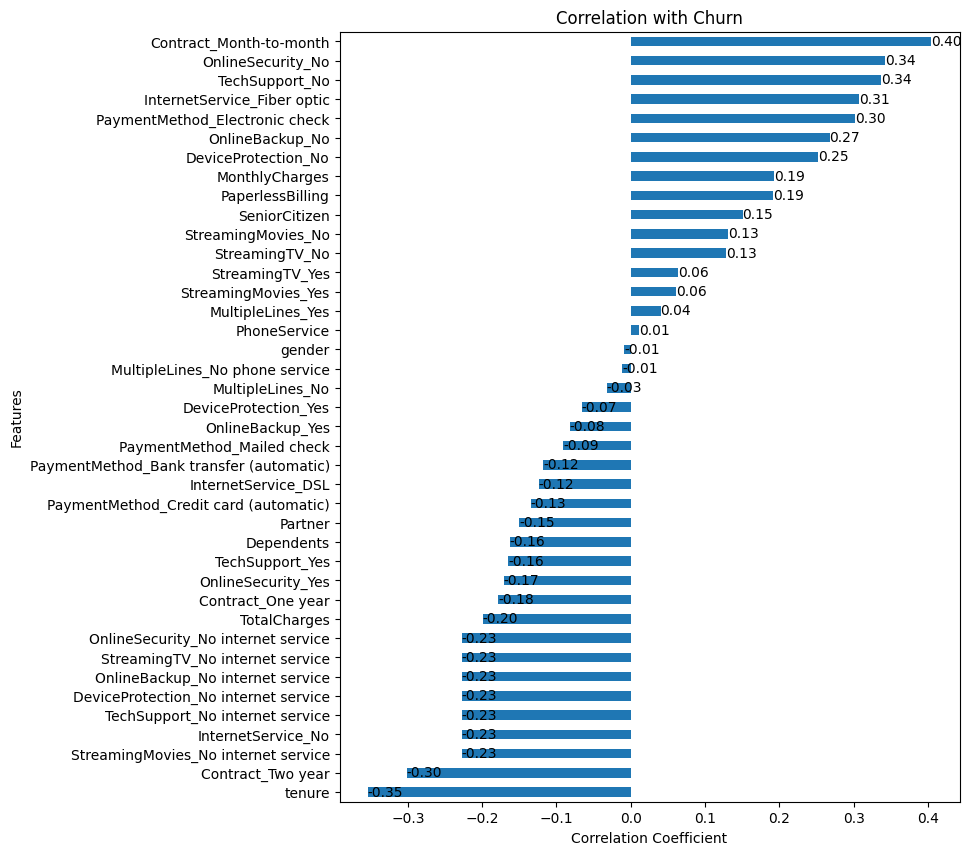

In [15]:
# Calculate correlations with the target variable 'Churn'
churn_corr = df.corr(numeric_only=True)['Churn']

# Exclude the correlation of Churn with itself for the plot
churn_corr = churn_corr.drop('Churn')

churn_corr_sorted = churn_corr.reindex(churn_corr.sort_values(ascending=True).index)


plt.figure(figsize=(8, 10))
ax = churn_corr_sorted.plot(kind='barh')
plt.title('Correlation with Churn')
plt.ylabel('Features')
plt.xlabel('Correlation Coefficient')

for index, value in enumerate(churn_corr_sorted):
  ax.text(value, index, f'{value:.2f}', va='center')

plt.show()

## Train / Test split (stratified)

In [16]:
X = df.drop('Churn', axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)
cols = X_train.columns.tolist()

X_train: (5625, 40) X_test: (1407, 40)
y_train: (5625,) y_test: (1407,)


## Model sweep

In [17]:
rng=42

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)

In [19]:
np.any(X_train.isna())

np.False_

In [20]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

# для категоріальних — нічого не робимо
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", "passthrough", cat_cols)
])


## 5.1 GridSearch for KNN


KNN best params: {'clf__metric': 'minkowski', 'clf__n_neighbors': 80, 'clf__weights': 'uniform'}
KNN best CV F1: 0.629


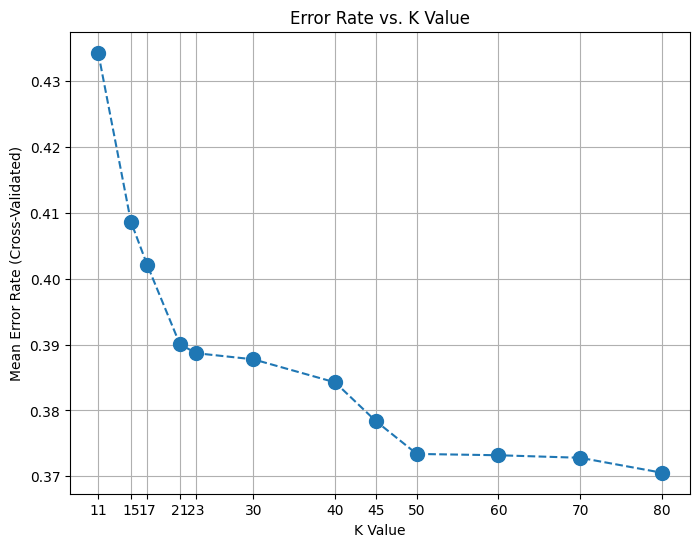

In [21]:

knn_pipe = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier())])
knn_grid = {
    "clf__n_neighbors": [11, 15, 17, 21, 23, 30, 40, 45, 50, 60, 70, 80],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ('minkowski', 'chebyshev')
}
knn_gs = GridSearchCV(knn_pipe, knn_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=0)
knn_gs.fit(X_train, y_train)
print("\nKNN best params:", knn_gs.best_params_)
print(f"KNN best CV F1: {knn_gs.best_score_:.3f}")

results = knn_gs.cv_results_
params = results['params']
mean_test_score = results['mean_test_score']

best_metric = knn_gs.best_params_['clf__metric']
best_weights = knn_gs.best_params_['clf__weights']

error_rate = []
k_values = [11, 15, 17, 21, 23, 30, 40, 45, 50, 60, 70, 80]
for i in k_values:
    knn = KNeighborsClassifier(n_neighbors=i, metric=best_metric, weights=best_weights)
    scores = cross_val_score(Pipeline([("prep", preprocessor), ("clf", knn)]), X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
    error_rate.append(1 - np.mean(scores))

plt.figure(figsize=(8,6))
plt.plot(k_values, error_rate, marker='o', linestyle='dashed', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error Rate (Cross-Validated)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [22]:
best_knn = Pipeline([("prep", preprocessor), ("clf", KNeighborsClassifier(metric='minkowski', n_neighbors=50, weights='uniform'))])

### 5.2 GridSearch for AdaBoost

In [23]:
adaboost_pipe = Pipeline([("prep", preprocessor), ("clf", AdaBoostClassifier(random_state=rng))])

# Define a parameter grid for AdaBoost. You can add more parameters to tune if needed.
adaboost_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.1, 0.5, 1.0]
}

adaboost_gs = GridSearchCV(adaboost_pipe, adaboost_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
adaboost_gs.fit(X_train, y_train)
best_adaboost = adaboost_gs.best_estimator_

print("\nAdaBoost best params:", adaboost_gs.best_params_)
print(f"AdaBoost best CV F1: {adaboost_gs.best_score_:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

AdaBoost best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 200}
AdaBoost best CV F1: 0.669


### 5.2 GridSearch for RandomForest

In [24]:
rf_pipe = Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(class_weight='balanced', random_state=rng))])

rf_grid = {
    'clf__n_estimators': [200, 300],
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [2, 4],
}

rf_gs = GridSearchCV(rf_pipe, rf_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_

print("\nRandomForest best params:", rf_gs.best_params_)
print(f"RandomForest best CV F1: {rf_gs.best_score_:.3f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits

RandomForest best params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}
RandomForest best CV F1: 0.667


## 5.4 GridSearch for SVM

In [26]:
svm_pipe = Pipeline([("prep", preprocessor), ("clf", SVC(probability=True, random_state=rng))])

svm_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto'],
    'clf__kernel': ['rbf']
}

svm_gs = GridSearchCV(svm_pipe, svm_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
svm_gs.fit(X_train, y_train)
best_svm = svm_gs.best_estimator_

print("\nSVM best params:", svm_gs.best_params_)
print(f"SVM best CV F1: {svm_gs.best_score_:.3f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

SVM best params: {'clf__C': 0.1, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
SVM best CV F1: 0.652


## 5.5 GridSearch for Logistic Regression

In [27]:
logreg_pipe = Pipeline([("prep", preprocessor), ("clf", LogisticRegression(random_state=rng))])

logreg_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2'],
    'clf__solver': ['liblinear', 'lbfgs']
}

logreg_gs = GridSearchCV(logreg_pipe, logreg_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
logreg_gs.fit(X_train, y_train)
best_logreg = logreg_gs.best_estimator_

print("\nLogistic Regression best params:", logreg_gs.best_params_)
print(f"Logistic Regression best CV AP: {logreg_gs.best_score_:.3f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Logistic Regression best params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Logistic Regression best CV AP: 0.660


## 5.6 GridSearch for Decision Tree

In [28]:
dt_pipe = Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(random_state=rng))])

dt_grid = {
    'clf__max_depth': [3, 5, 7, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__criterion': ['gini', 'entropy']
}

dt_gs = GridSearchCV(dt_pipe, dt_grid, scoring="average_precision", cv=cv, n_jobs=-1, verbose=1)
dt_gs.fit(X_train, y_train)
best_dt = dt_gs.best_estimator_

print("\nDecision Tree best params:", dt_gs.best_params_)
print(f"Decision Tree best CV AP: {dt_gs.best_score_:.3f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits

Decision Tree best params: {'clf__criterion': 'entropy', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Decision Tree best CV AP: 0.613


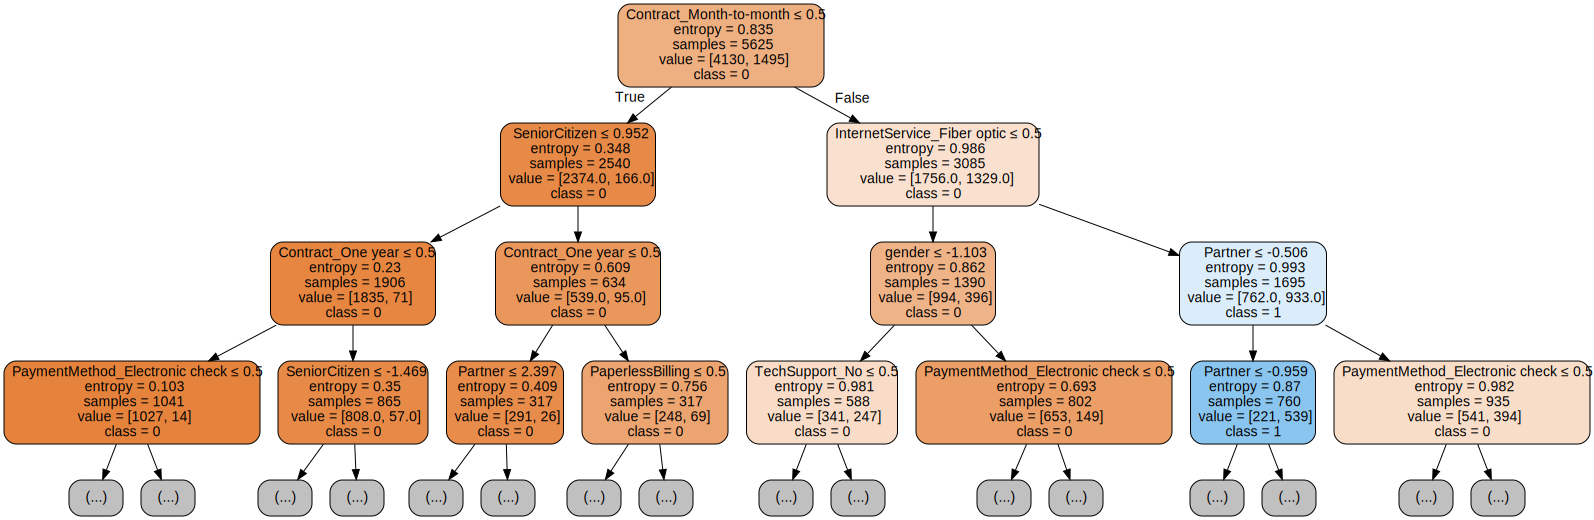

In [29]:
from sklearn.tree import export_graphviz
import graphviz

dt_clf = best_dt.named_steps['clf']
feature_names = list(X_train.columns)

dot_data = export_graphviz(
    dt_clf,
    out_file=None,
    feature_names=feature_names,
    class_names=['0', '1'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3
)

graph = graphviz.Source(dot_data)
display(graph)

In [30]:
candidates = {
    "KNN": best_knn,
    "AdaBoost": best_adaboost,
    "RandomForest": best_rf,
    "SVM": best_svm,
    "LogReg": best_logreg,
    "DecisionTree": best_dt
}

def fit_and_pick_threshold(pipe, X_tr, y_tr, cv):
    oof_proba = cross_val_predict(pipe, X_tr, y_tr, cv=cv, method="predict_proba", n_jobs=-1)[:,1]
    prec, rec, thr = precision_recall_curve(y_tr, oof_proba)
    f1s = 2*prec[1:]*rec[1:] / (prec[1:] + rec[1:] + 1e-12)
    best_idx = np.argmax(f1s)
    best_thr = thr[best_idx]
    return best_thr, f1s[best_idx]

thresholds = {}
for name, est in candidates.items():
    thr, f1oof = fit_and_pick_threshold(est, X_train, y_train, cv)
    thresholds[name] = (thr, f1oof)
    print(f"{name:14s} OOF-best thr = {thr:.3f} | OOF F1 = {f1oof:.3f}")

KNN            OOF-best thr = 0.400 | OOF F1 = 0.624
AdaBoost       OOF-best thr = 0.444 | OOF F1 = 0.640
RandomForest   OOF-best thr = 0.468 | OOF F1 = 0.643
SVM            OOF-best thr = 0.254 | OOF F1 = 0.631
LogReg         OOF-best thr = 0.323 | OOF F1 = 0.639
DecisionTree   OOF-best thr = 0.320 | OOF F1 = 0.623



=== Порівняння метрик (Test set) ===
Model          | Metric          | Predict()  | >=thr     
------------------------------------------------------------
RandomForest   | F1 (class 1)    | 0.626      | 0.621     
               | Recall (class 1) | 0.754      | 0.783     
               | Precision (class 1) | 0.535      | 0.514     
               | ROC-AUC         | 0.833      | 0.833     
               | AP              | 0.637      | 0.637     
------------------------------------------------------------
SVM            | F1 (class 1)    | 0.550      | 0.620     
               | Recall (class 1) | 0.481      | 0.722     
               | Precision (class 1) | 0.641      | 0.543     
               | ROC-AUC         | 0.824      | 0.824     
               | AP              | 0.618      | 0.618     
------------------------------------------------------------
AdaBoost       | F1 (class 1)    | 0.561      | 0.616     
               | Recall (class 1) | 0.516      | 0.733     
 

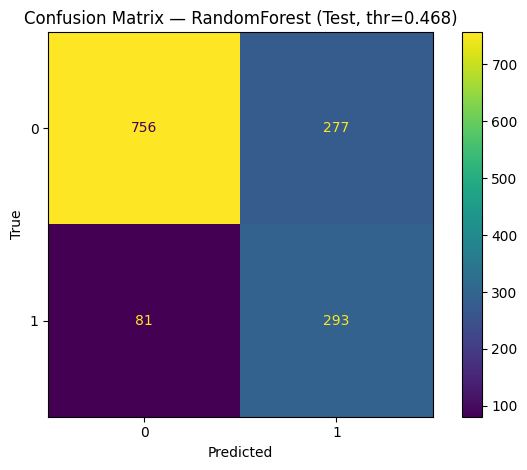

SVM


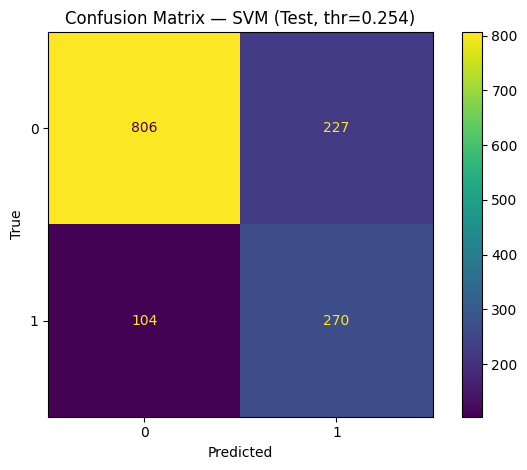

AdaBoost


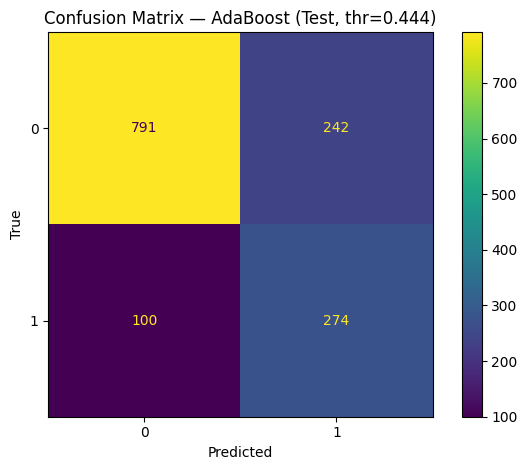

DecisionTree


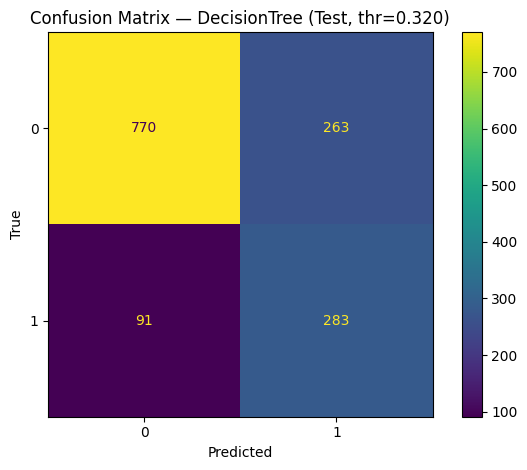

KNN


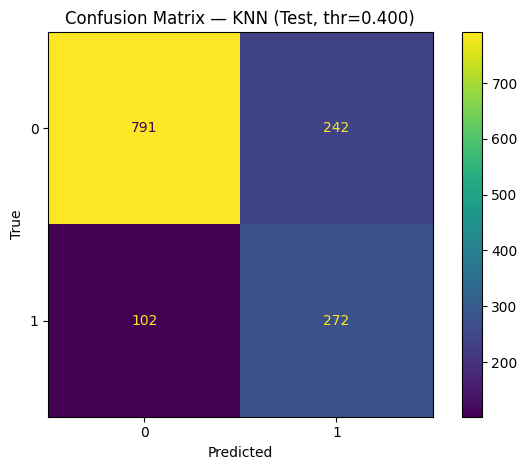

LogReg


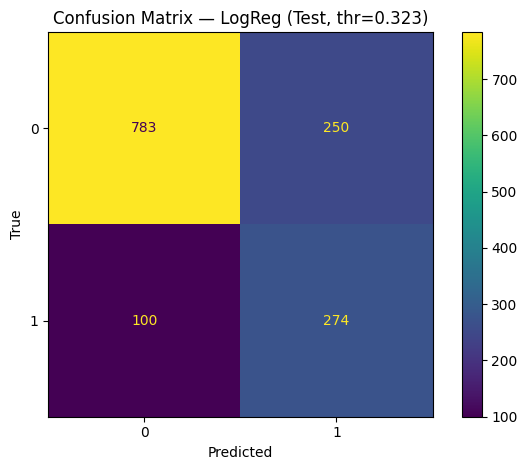

In [31]:
results = []
for name, est in candidates.items():
    est.fit(X_train, y_train)
    proba = est.predict_proba(X_test)[:,1]
    thr = thresholds[name][0]

    # Metrics using predict()
    y_pred_default = est.predict(X_test)
    rep_default = classification_report(y_test, y_pred_default, output_dict=True)
    f1_default = rep_default['1']['f1-score']
    recall_default = rep_default['1']['recall']
    precision_default = rep_default['1']['precision']
    roc_default = roc_auc_score(y_test, proba)
    ap_default  = average_precision_score(y_test, proba)


    # Metrics using best_thr
    y_pred_thr = (proba >= thr).astype(int)
    rep_thr = classification_report(y_test, y_pred_thr, output_dict=True)
    f1_thr  = rep_thr['1']['f1-score']
    recall_thr = rep_thr['1']['recall']
    precision_thr = rep_thr['1']['precision']
    roc_thr = roc_auc_score(y_test, proba)
    ap_thr  = average_precision_score(y_test, proba)

    results.append((name, f1_default, recall_default, precision_default, roc_default, ap_default, y_pred_default,
                    f1_thr, recall_thr, precision_thr, roc_thr, ap_thr, y_pred_thr, thr))


print("\n=== Порівняння метрик (Test set) ===")
print(f"{'Model':<14s} | {'Metric':<15s} | {'Predict()':<10s} | {'>=thr':<10s}")
print("-" * 60)

# Sort by F1 using threshold for consistent ordering
results.sort(key=lambda x: x[7], reverse=True)

for name, f1_def, rec_def, prec_def, roc_def, ap_def, _, f1_thr, rec_thr, prec_thr, roc_thr, ap_thr, _, thr in results:
    print(f"{name:<14s} | {'F1 (class 1)':<15s} | {f1_def:<10.3f} | {f1_thr:<10.3f}")
    print(f"{'':<14s} | {'Recall (class 1)':<15s} | {rec_def:<10.3f} | {rec_thr:<10.3f}")
    print(f"{'':<14s} | {'Precision (class 1)':<15s} | {prec_def:<10.3f} | {prec_thr:<10.3f}")
    print(f"{'':<14s} | {'ROC-AUC':<15s} | {roc_def:<10.3f} | {roc_thr:<10.3f}")
    print(f"{'':<14s} | {'AP':<15s} | {ap_def:<10.3f} | {ap_thr:<10.3f}")
    print("-" * 60)


print("\n=== Матриці невідповідностей (Test set) ===")
for name, _, _, _, _, _, _, _, _, _, _, _, y_pred_thr, thr in results:
    cm = confusion_matrix(y_test, y_pred_thr)
    print(name)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0','1'])
    disp.plot(values_format='d')
    plt.title(f'Confusion Matrix — {name} (Test, thr={thr:.3f})')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.tight_layout()
    plt.show()